In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

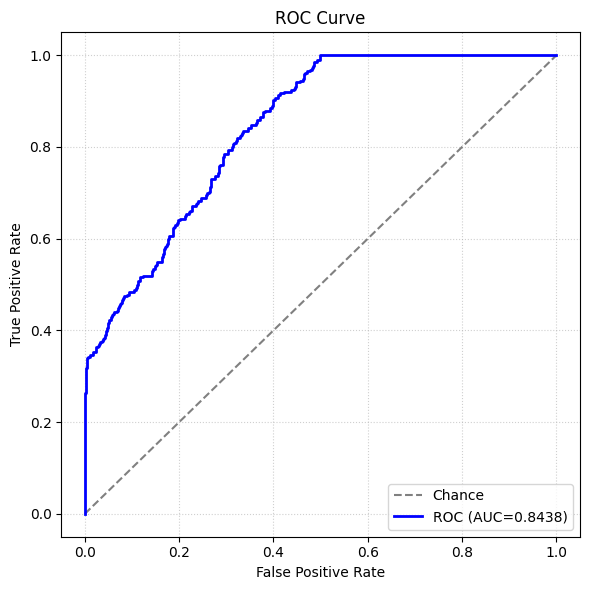

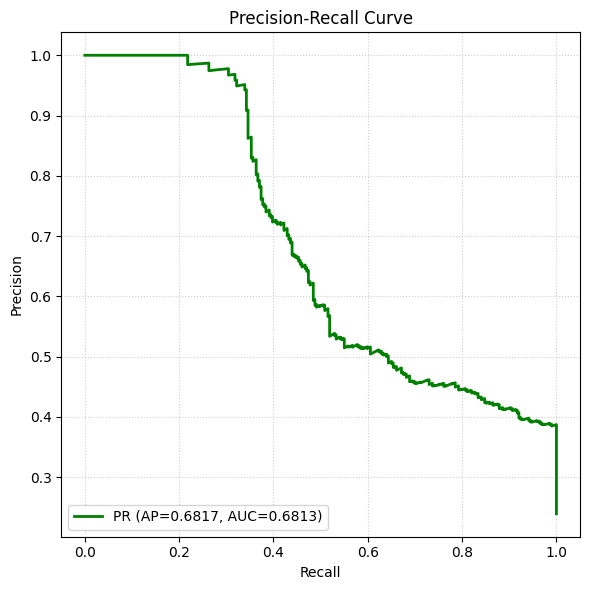

ROC-AUC: 0.843782
(as-is: 0.843782, inverted: 0.156218)
Average Precision (AP): 0.681720
PR-AUC (trapz): 0.681277
Positives: 289 / 1207 (prevalence=0.2394)


In [25]:
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, auc
)
import numpy as np
import matplotlib.pyplot as plt

file_path = "darpa_anomaly.txt"


scores, labels = [], []
with open(file_path, "r") as f:
    for line in f:
        if not line.strip():
            continue
        parts = line.replace(",", " ").split()
        if len(parts) < 2:
            continue
        s, y = float(parts[0]), int(float(parts[1]))
        scores.append(s)
        labels.append(y)

scores = np.array(scores, float)
labels = np.array(labels, int)


if len(set(labels)) < 2:
    raise ValueError("Need at least one positive (1) and one negative (0) label for ROC-AUC.")


roc_auc_normal = roc_auc_score(labels, scores)
roc_auc_inverted = roc_auc_score(labels, -scores)
roc_auc = max(roc_auc_normal, roc_auc_inverted)


use_inverted = roc_auc_inverted > roc_auc_normal
y_score = -scores if use_inverted else scores


fpr, tpr, _ = roc_curve(labels, y_score)
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC (AUC={roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


prec, rec, _ = precision_recall_curve(labels, y_score)
ap = average_precision_score(labels, y_score)
pr_auc = auc(rec, prec)

# Note : AP stands for Average Precision.
plt.figure(figsize=(6,6))
plt.plot(rec, prec, color='green', lw=2,
         label=f"PR (AP={ap:.4f}, AUC={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

print(f"ROC-AUC: {roc_auc:.6f}")
print(f"(as-is: {roc_auc_normal:.6f}, inverted: {roc_auc_inverted:.6f})")
print(f"Average Precision (AP): {ap:.6f}")
print(f"PR-AUC (trapz): {pr_auc:.6f}")
print(f"Positives: {labels.sum()} / {len(labels)} (prevalence={labels.mean():.4f})")


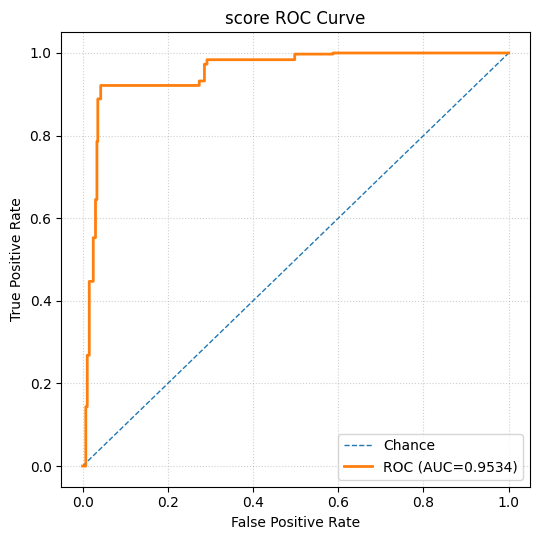

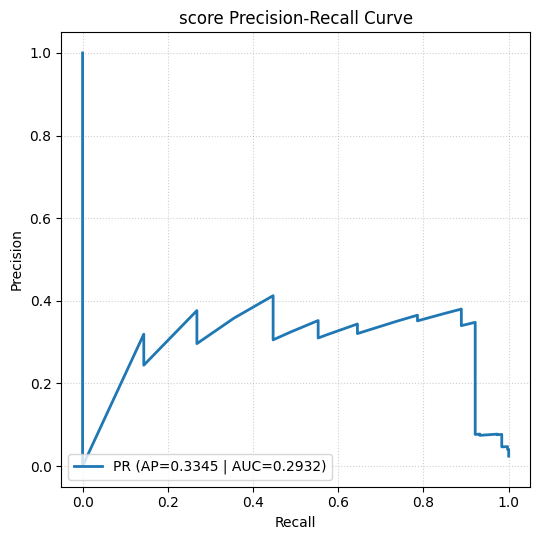

score ROC-AUC: 0.953404
score Average Precision (AP): 0.334513
score PR-AUC (trapz): 0.293171
Positives: 369 / 15346 (prevalence=0.0240)


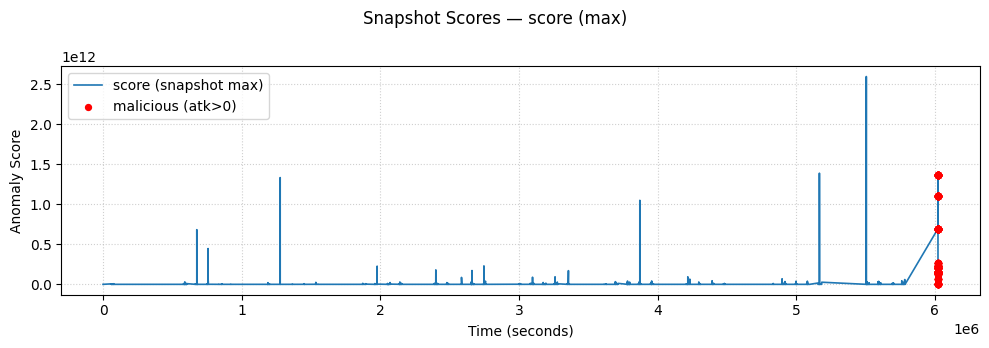

In [11]:
# anomrank_eval_toggle.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)

# ========= Config =========
CSV_PATH   = "anomrank_user12_combined_or_edge_anomaly.csv"
TIME_COL   = "t"
ATTACK_COL = "atk"
SCORE_COLS = ["score"]
AGG        = "max"        
TIME_UNIT  = "seconds"
EVAL_MODE  = "snapshot"   


df = pd.read_csv(CSV_PATH)

missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS).copy()
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)


if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0}).astype({"atk_binary": int})
g.index.name = TIME_COL

def compute_and_plot_metrics(y_true, y_score, title_prefix=""):
    """Compute ROC-AUC, AP, PR-AUC and plot ROC/PR curves."""
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if y_true.max() == 0:
        raise ValueError("No positive samples in y_true. Cannot compute PR/ROC.")
    if y_true.min() == 1:
        raise ValueError("No negative samples in y_true. Cannot compute PR/ROC.")

    roc = roc_auc_score(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    pr_auc = auc(rec, prec)

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.4f} | AUC={pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} ROC-AUC: {roc:.6f}")
    print(f"{title_prefix} Average Precision (AP): {ap:.6f}")
    print(f"{title_prefix} PR-AUC (trapz): {pr_auc:.6f}")
    print(f"Positives: {y_true.sum()} / {len(y_true)} (prevalence={y_true.mean():.4f})")

def plot_timeline(ax, times, scores, y_true, label, time_unit="seconds"):
    ax.plot(times, scores, linewidth=1.2, label=label)
    atk_mask = y_true.astype(bool)
    if atk_mask.any():
        ax.scatter(times[atk_mask], scores[atk_mask], s=18, color="red", marker="o",
                   label="malicious (atk>0)", zorder=5)
    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Time ({time_unit})")

if EVAL_MODE == "snapshot":
    for col in SCORE_COLS:
        y_true_snap = g["atk_binary"].to_numpy()
        y_score_snap = g[col].to_numpy()

        compute_and_plot_metrics(y_true_snap, y_score_snap,
                                 title_prefix=f"{col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        times_snap = g.index.to_numpy()
        plot_timeline(ax, times_snap, y_score_snap, y_true_snap,
                      label=f"{col} (snapshot {AGG})", time_unit=TIME_UNIT)
        fig.suptitle(f"Snapshot Scores — {col} ({AGG})")
        fig.tight_layout()
        plt.show()

elif EVAL_MODE == "edge":
    for col in SCORE_COLS:
        times_edge = df[TIME_COL].to_numpy()
        y_true_edge = df["atk_binary"].to_numpy()
        y_score_edge = df[col].to_numpy()

        compute_and_plot_metrics(y_true_edge, y_score_edge,
                                 title_prefix=f"[EDGE] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(times_edge, y_score_edge, linewidth=0.8, alpha=0.8,
                label=f"{col} (per-edge)")
        atk_mask = y_true_edge.astype(bool)
        if atk_mask.any():
            ax.scatter(times_edge[atk_mask], y_score_edge[atk_mask],
                       s=12, color="red", marker="o", label="malicious (atk>0)", zorder=5)
        ax.set_ylabel("Anomaly Score")
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.legend(loc="upper left")
        ax.set_xlabel(f"Time ({TIME_UNIT})")
        fig.suptitle("Anomaly Scores — Per-Edge Timeline (malicious edges in red)")
        fig.tight_layout()
        plt.show()
else:
    raise ValueError("EVAL_MODE must be 'snapshot' or 'edge'")


User7

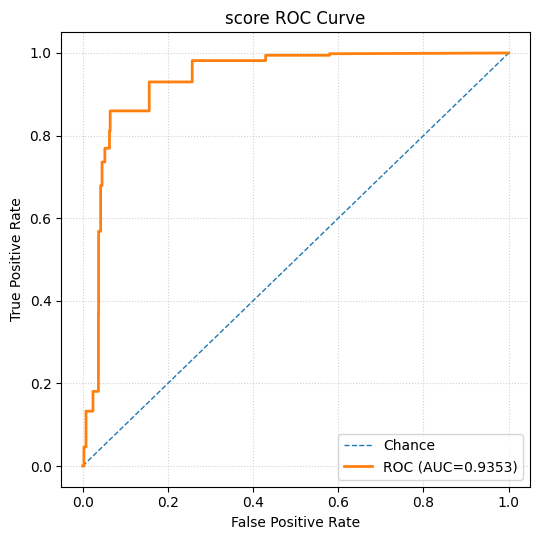

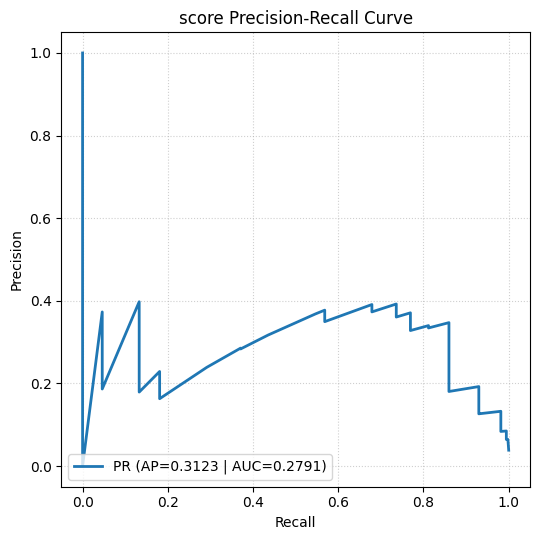

score ROC-AUC: 0.935276
score Average Precision (AP): 0.312286
score PR-AUC (trapz): 0.279133
Positives: 542 / 14068 (prevalence=0.0385)


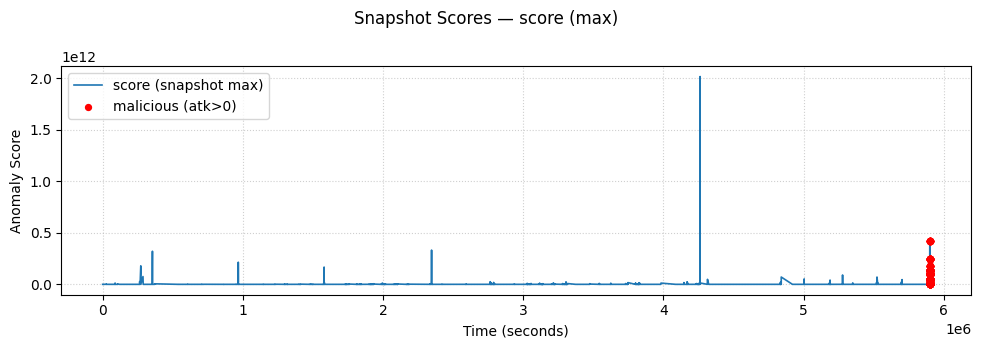

In [3]:
# anomrank_eval_toggle.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)

# ========= Config =========
CSV_PATH   = "anomrank_user7_combined_or_edge_anomaly.csv"
TIME_COL   = "t"
ATTACK_COL = "atk"
SCORE_COLS = ["score"]
AGG        = "max"        
TIME_UNIT  = "seconds"
EVAL_MODE  = "snapshot"   
SEED       = 42


df = pd.read_csv(CSV_PATH)

missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS).copy()
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)


if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0}).astype({"atk_binary": int})
g.index.name = TIME_COL

def compute_and_plot_metrics(y_true, y_score, title_prefix=""):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if y_true.max() == 0:
        raise ValueError("No positive samples in y_true. Cannot compute PR/ROC.")
    if y_true.min() == 1:
        raise ValueError("No negative samples in y_true. Cannot compute PR/ROC.")

    roc = roc_auc_score(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    pr_auc = auc(rec, prec)

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.4f} | AUC={pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} ROC-AUC: {roc:.6f}")
    print(f"{title_prefix} Average Precision (AP): {ap:.6f}")
    print(f"{title_prefix} PR-AUC (trapz): {pr_auc:.6f}")
    print(f"Positives: {y_true.sum()} / {len(y_true)} (prevalence={y_true.mean():.4f})")

def plot_timeline(ax, times, scores, y_true, label, time_unit="seconds"):
    ax.plot(times, scores, linewidth=1.2, label=label)
    atk_mask = y_true.astype(bool)
    if atk_mask.any():
        ax.scatter(times[atk_mask], scores[atk_mask], s=18, color="red", marker="o",
                   label="malicious (atk>0)", zorder=5)
    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Time ({time_unit})")

if EVAL_MODE == "snapshot":
    for col in SCORE_COLS:
        y_true_snap = g["atk_binary"].to_numpy()
        y_score_snap = g[col].to_numpy()

        compute_and_plot_metrics(y_true_snap, y_score_snap,
                                 title_prefix=f"{col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        times_snap = g.index.to_numpy()
        plot_timeline(ax, times_snap, y_score_snap, y_true_snap,
                      label=f"{col} (snapshot {AGG})", time_unit=TIME_UNIT)
        fig.suptitle(f"Snapshot Scores — {col} ({AGG})")
        fig.tight_layout()
        plt.show()

elif EVAL_MODE == "edge":
    for col in SCORE_COLS:
        times_edge = df[TIME_COL].to_numpy()
        y_true_edge = df["atk_binary"].to_numpy()
        y_score_edge = df[col].to_numpy()

        compute_and_plot_metrics(y_true_edge, y_score_edge,
                                 title_prefix=f"[EDGE] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(times_edge, y_score_edge, linewidth=0.8, alpha=0.8,
                label=f"{col} (per-edge)")
        atk_mask = y_true_edge.astype(bool)
        if atk_mask.any():
            ax.scatter(times_edge[atk_mask], y_score_edge[atk_mask],
                       s=12, color="red", marker="o", label="malicious (atk>0)", zorder=5)
        ax.set_ylabel("Anomaly Score")
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.legend(loc="upper left")
        ax.set_xlabel(f"Time ({TIME_UNIT})")
        fig.suptitle("Anomaly Scores — Per-Edge Timeline (malicious edges in red)")
        fig.tight_layout()
        plt.show()
else:
    raise ValueError("EVAL_MODE must be 'snapshot' or 'edge'")


In [ ]:

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# ---------- CONFIG ----------
txt_path = "user1_organized_combined_anomaly.txt"   # <-- set to your input file
# ---------------------------

text = Path(txt_path).read_text(encoding="utf-8")
lines = [ln for ln in text.splitlines() if ln.strip()]

# Detect format
re_summary = re.compile(
    r"^\s*(?:\[[^\]]+\]\s*)?precision:\s*(\d*\.?\d+(?:[eE][-+]?\d+)?)\s*,\s*recall:\s*(\d*\.?\d+(?:[eE][-+]?\d+)?)",
    re.IGNORECASE,
)
re_pair = re.compile(
    r"^\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s+([01])\s*$"
)

n_summary = sum(1 for ln in lines if re_summary.match(ln))
n_pairs   = sum(1 for ln in lines if re_pair.match(ln))

if n_summary == 0 and n_pairs == 0:
    raise ValueError("Input not recognized. Expect either:\n"
                     "  [LABEL] precision: <num>, recall: <num>\n"
                     "or\n"
                     "  <score> <label(0/1)>")

# ========== MODE 1: Top-K summary points ==========
if n_summary >= n_pairs:
    prs = []
    for ln in lines:
        m = re_summary.match(ln)
        if m:
            p, r = map(float, m.groups())
            prs.append((p, r))
    if not prs:
        raise ValueError("No valid summary lines parsed.")
    df = pd.DataFrame(prs, columns=["precision","recall"]).sort_values("recall")
    precision = df["precision"].to_numpy()
    recall    = df["recall"].to_numpy()

    # PR-AUC (trapezoidal)
    auc = float(np.trapz(precision, recall))

    print(f"Detected format: Top-K summary points")
    print(f"PR-AUC (trapezoidal): {auc:.6f}")

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker="o", linestyle="-")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve (AUC = {auc:.4f})")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

# ========== MODE 2: Raw score/label pairs ==========
else:
    scores, labels = [], []
    for ln in lines:
        m = re_pair.match(ln)
        if m:
            s = float(m.group(1))
            y = int(m.group(2))
            scores.append(s); labels.append(y)

    if not scores:
        raise ValueError("No valid score/label lines parsed.")
    scores = np.asarray(scores, dtype=float)
    labels = np.asarray(labels, dtype=int)
    if labels.max() > 1 or labels.min() < 0:
        raise ValueError("Labels must be 0 or 1.")

    # Sort by score descending
    order = np.argsort(-scores)
    scores = scores[order]
    labels = labels[order]

    P = labels.sum()
    if P == 0:
        raise ValueError("No positive labels (1) found; PR curve undefined.")

    # Compute PR at each unique threshold (standard cumulative approach)
    tp = np.cumsum(labels)
    fp = np.cumsum(1 - labels)
    precision = tp / (tp + fp)
    recall = tp / P

    _, last_idx = np.unique(scores, return_index=False, return_counts=False, return_inverse=False), None

    change = np.r_[True, np.diff(scores) != 0]
    precision = precision[change]
    recall    = recall[change]

    # PR-AUC (trapezoidal)
    auc = float(np.trapz(precision, recall))

    print(f"Detected format: score/label pairs")
    print(f"PR-AUC (trapezoidal): {auc:.6f}")

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker="o", linestyle="-")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve (AUC = {auc:.4f})")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()


ValueError: No positive labels (1) found; PR curve undefined.

User 12

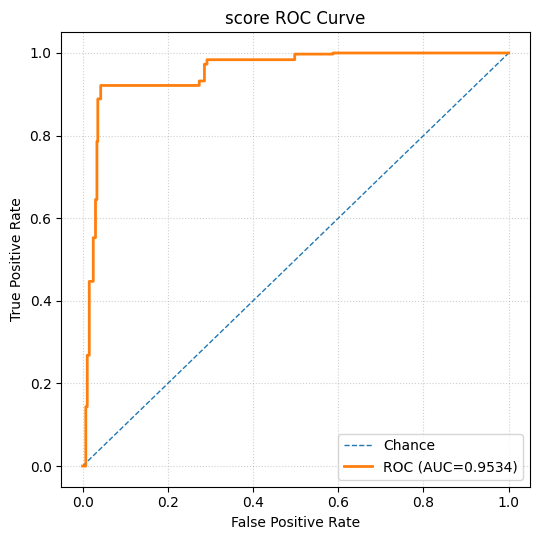

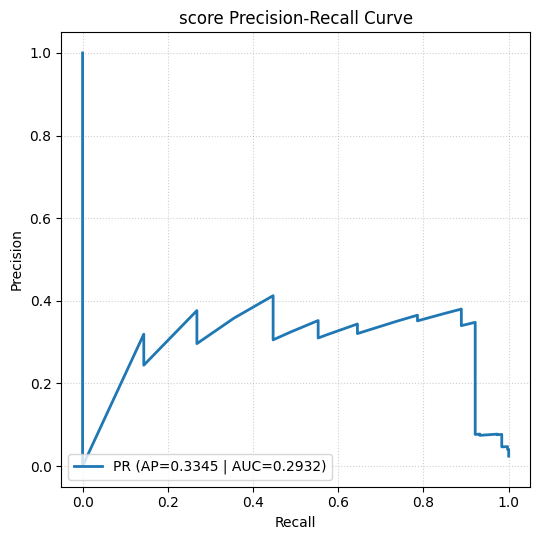

score ROC-AUC: 0.953404
score Average Precision (AP): 0.334513
score PR-AUC (trapz): 0.293171
Positives: 369 / 15346 (prevalence=0.0240)


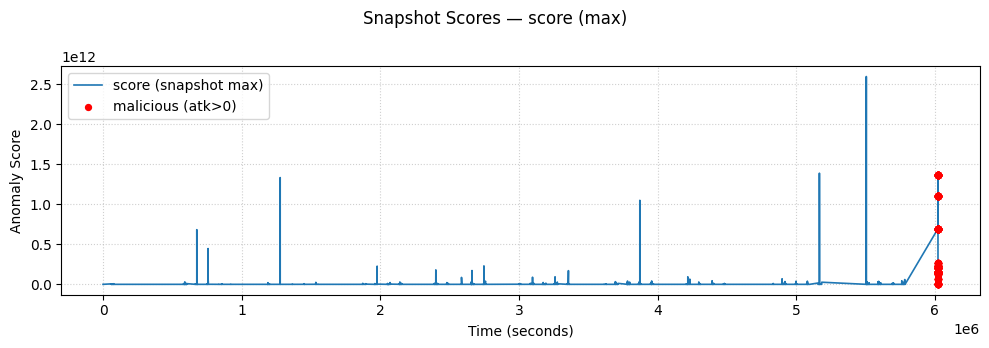

In [4]:
# anomrank_eval_toggle.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)

# ========= Config =========
CSV_PATH   = "anomrank_user12_combined_or_edge_anomaly.csv"
TIME_COL   = "t"
ATTACK_COL = "atk"
SCORE_COLS = ["score"]
AGG        = "max"        
TIME_UNIT  = "seconds"
EVAL_MODE  = "snapshot"   
SEED       = 42


df = pd.read_csv(CSV_PATH)

missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS).copy()
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)


if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0}).astype({"atk_binary": int})
g.index.name = TIME_COL

def compute_and_plot_metrics(y_true, y_score, title_prefix=""):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if y_true.max() == 0:
        raise ValueError("No positive samples in y_true. Cannot compute PR/ROC.")
    if y_true.min() == 1:
        raise ValueError("No negative samples in y_true. Cannot compute PR/ROC.")

    roc = roc_auc_score(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    pr_auc = auc(rec, prec)

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.4f} | AUC={pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} ROC-AUC: {roc:.6f}")
    print(f"{title_prefix} Average Precision (AP): {ap:.6f}")
    print(f"{title_prefix} PR-AUC (trapz): {pr_auc:.6f}")
    print(f"Positives: {y_true.sum()} / {len(y_true)} (prevalence={y_true.mean():.4f})")

def plot_timeline(ax, times, scores, y_true, label, time_unit="seconds"):
    ax.plot(times, scores, linewidth=1.2, label=label)
    atk_mask = y_true.astype(bool)
    if atk_mask.any():
        ax.scatter(times[atk_mask], scores[atk_mask], s=18, color="red", marker="o",
                   label="malicious (atk>0)", zorder=5)
    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Time ({time_unit})")

if EVAL_MODE == "snapshot":
    for col in SCORE_COLS:
        y_true_snap = g["atk_binary"].to_numpy()
        y_score_snap = g[col].to_numpy()

        compute_and_plot_metrics(y_true_snap, y_score_snap,
                                 title_prefix=f"{col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        times_snap = g.index.to_numpy()
        plot_timeline(ax, times_snap, y_score_snap, y_true_snap,
                      label=f"{col} (snapshot {AGG})", time_unit=TIME_UNIT)
        fig.suptitle(f"Snapshot Scores — {col} ({AGG})")
        fig.tight_layout()
        plt.show()

elif EVAL_MODE == "edge":
    for col in SCORE_COLS:
        times_edge = df[TIME_COL].to_numpy()
        y_true_edge = df["atk_binary"].to_numpy()
        y_score_edge = df[col].to_numpy()

        compute_and_plot_metrics(y_true_edge, y_score_edge,
                                 title_prefix=f"[EDGE] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(times_edge, y_score_edge, linewidth=0.8, alpha=0.8,
                label=f"{col} (per-edge)")
        atk_mask = y_true_edge.astype(bool)
        if atk_mask.any():
            ax.scatter(times_edge[atk_mask], y_score_edge[atk_mask],
                       s=12, color="red", marker="o", label="malicious (atk>0)", zorder=5)
        ax.set_ylabel("Anomaly Score")
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.legend(loc="upper left")
        ax.set_xlabel(f"Time ({TIME_UNIT})")
        fig.suptitle("Anomaly Scores — Per-Edge Timeline (malicious edges in red)")
        fig.tight_layout()
        plt.show()
else:
    raise ValueError("EVAL_MODE must be 'snapshot' or 'edge'")


Darpa Dataset, Darpa Dataset is large..Therefore when loaded onto excel, some data might get lost

In [5]:

df = pd.read_csv("darpa_edge_anomaly.csv")
print("score stats:", df["score"].min(), df["score"].max())

score stats: 0.0 207027406.797019


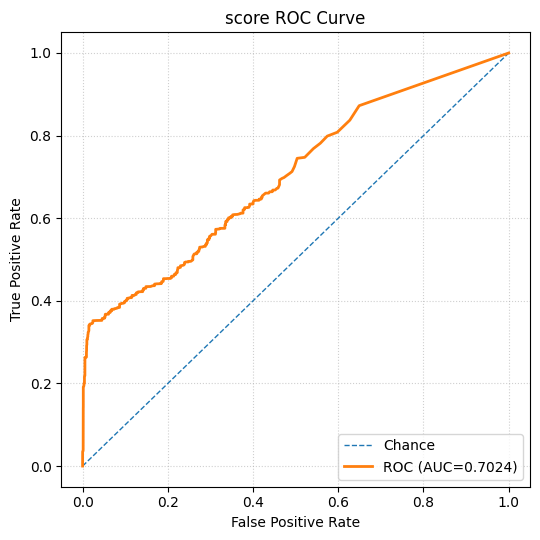

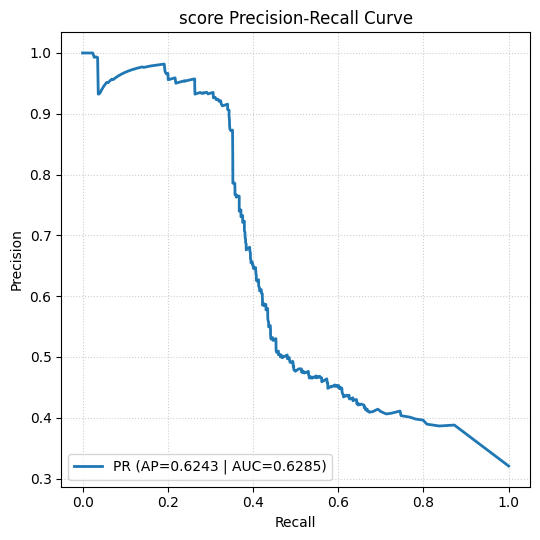

score ROC-AUC: 0.702414
score Average Precision (AP): 0.624327
score PR-AUC (trapz): 0.628528
Positives: 14926 / 46567 (prevalence=0.3205)


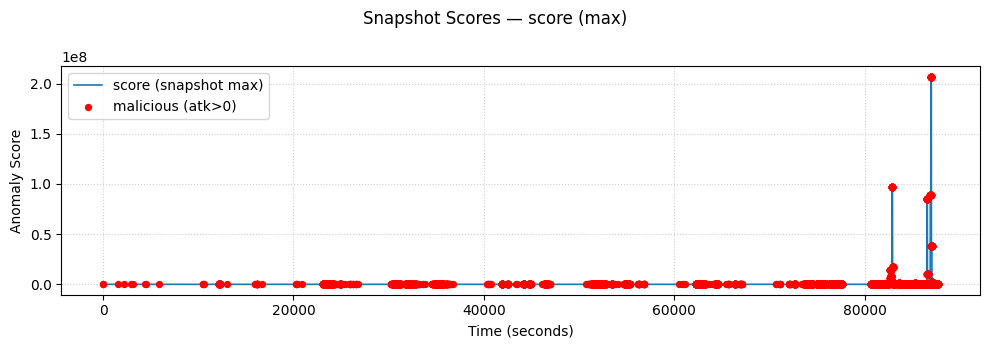

In [6]:
# anomrank_eval_toggle.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)

# ========= Config =========
CSV_PATH   = "darpa_edge_anomaly.csv"
TIME_COL   = "t"
ATTACK_COL = "atk"
SCORE_COLS = ["score"]
AGG        = "max"        
TIME_UNIT  = "seconds"
EVAL_MODE  = "snapshot"   
SEED       = 42


df = pd.read_csv(CSV_PATH)

missing = {TIME_COL, ATTACK_COL}.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")
for c in SCORE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing score column '{c}'. Available: {list(df.columns)}")

df[TIME_COL]   = pd.to_numeric(df[TIME_COL], errors="coerce")
df[ATTACK_COL] = pd.to_numeric(df[ATTACK_COL], errors="coerce")
for c in SCORE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TIME_COL, ATTACK_COL] + SCORE_COLS).copy()
df["atk_binary"] = (df[ATTACK_COL] > 0).astype(int)


if AGG not in {"max", "mean", "sum"}:
    raise ValueError("AGG must be one of {'max','mean','sum'}")

score_agg = df.groupby(TIME_COL)[SCORE_COLS].agg(AGG)
attack_by_t = df.groupby(TIME_COL)["atk_binary"].max()
g = score_agg.join(attack_by_t, how="left").fillna({"atk_binary": 0}).astype({"atk_binary": int})
g.index.name = TIME_COL

def compute_and_plot_metrics(y_true, y_score, title_prefix=""):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    if y_true.max() == 0:
        raise ValueError("No positive samples in y_true. Cannot compute PR/ROC.")
    if y_true.min() == 1:
        raise ValueError("No negative samples in y_true. Cannot compute PR/ROC.")

    roc = roc_auc_score(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    pr_auc = auc(rec, prec)

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.4f} | AUC={pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} ROC-AUC: {roc:.6f}")
    print(f"{title_prefix} Average Precision (AP): {ap:.6f}")
    print(f"{title_prefix} PR-AUC (trapz): {pr_auc:.6f}")
    print(f"Positives: {y_true.sum()} / {len(y_true)} (prevalence={y_true.mean():.4f})")

def plot_timeline(ax, times, scores, y_true, label, time_unit="seconds"):
    ax.plot(times, scores, linewidth=1.2, label=label)
    atk_mask = y_true.astype(bool)
    if atk_mask.any():
        ax.scatter(times[atk_mask], scores[atk_mask], s=18, color="red", marker="o",
                   label="malicious (atk>0)", zorder=5)
    ax.set_ylabel("Anomaly Score")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Time ({time_unit})")

if EVAL_MODE == "snapshot":
    for col in SCORE_COLS:
        y_true_snap = g["atk_binary"].to_numpy()
        y_score_snap = g[col].to_numpy()

        compute_and_plot_metrics(y_true_snap, y_score_snap,
                                 title_prefix=f"{col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        times_snap = g.index.to_numpy()
        plot_timeline(ax, times_snap, y_score_snap, y_true_snap,
                      label=f"{col} (snapshot {AGG})", time_unit=TIME_UNIT)
        fig.suptitle(f"Snapshot Scores — {col} ({AGG})")
        fig.tight_layout()
        plt.show()

elif EVAL_MODE == "edge":
    for col in SCORE_COLS:
        times_edge = df[TIME_COL].to_numpy()
        y_true_edge = df["atk_binary"].to_numpy()
        y_score_edge = df[col].to_numpy()

        compute_and_plot_metrics(y_true_edge, y_score_edge,
                                 title_prefix=f"[EDGE] {col}")

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(times_edge, y_score_edge, linewidth=0.8, alpha=0.8,
                label=f"{col} (per-edge)")
        atk_mask = y_true_edge.astype(bool)
        if atk_mask.any():
            ax.scatter(times_edge[atk_mask], y_score_edge[atk_mask],
                       s=12, color="red", marker="o", label="malicious (atk>0)", zorder=5)
        ax.set_ylabel("Anomaly Score")
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.legend(loc="upper left")
        ax.set_xlabel(f"Time ({TIME_UNIT})")
        fig.suptitle("Anomaly Scores — Per-Edge Timeline (malicious edges in red)")
        fig.tight_layout()
        plt.show()
else:
    raise ValueError("EVAL_MODE must be 'snapshot' or 'edge'")


PR-AUC (trapezoidal): 0.507649


C:\Users\seoji\AppData\Local\Temp\ipykernel_48028\2080324746.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(precision, recall)


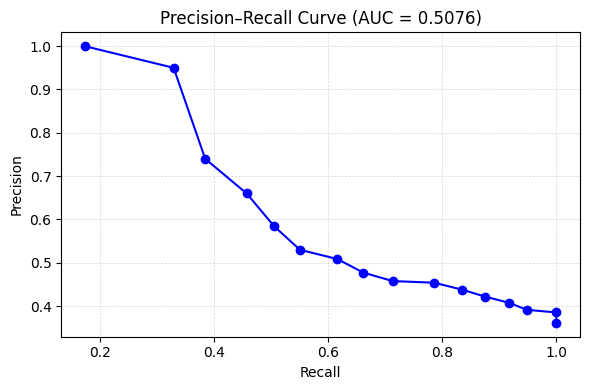

In [10]:
# === Simple PR Curve from text file (single-cell version) ===
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# ---- CONFIG ----
txt_path = "darpa_precision_recall.txt"   # <-- change this to your .txt file
# ----------------

# regex to extract precision and recall
LINE_RE = re.compile(
    r"^\s*(?:\[[^\]]+\]\s*)?precision:\s*(\d*\.?\d+(?:[eE][-+]?\d+)?)\s*,\s*recall:\s*(\d*\.?\d+(?:[eE][-+]?\d+)?)",
    re.IGNORECASE,
)

# ---- Parse text file ----
rows = []
for line in Path(txt_path).read_text(encoding="utf-8").splitlines():
    m = LINE_RE.match(line)
    if m:
        p, r = map(float, m.groups())
        rows.append((p, r))

if not rows:
    raise ValueError("No valid lines found! Expected format: [TOPX] precision: <num>, recall: <num>")

# ---- DataFrame + Sort ----
df = pd.DataFrame(rows, columns=["precision", "recall"]).sort_values("recall")
precision = df["precision"].to_numpy()
recall = df["recall"].to_numpy()

# ---- Compute AUC ----
auc = np.trapz(precision, recall)

# ---- Print results ----
print(f"PR-AUC (trapezoidal): {auc:.6f}")

# ---- Plot ----
plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker="o", linestyle="-", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AUC = {auc:.4f})")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# === DARPA top-K evaluation from anomaly scores (no PR curve) ===
import re, numpy as np, pandas as pd
from pathlib import Path

# -------- CONFIG --------
path = "darpa_anomaly.txt"      
Ks   = list(range(50, 801, 50))
show_topk_table = True          
preview_top = 800               


p = Path(path)
if not p.exists():
    raise FileNotFoundError(f"Cannot find file: {p}")

def try_read_score_label_text(text: str):
    """Parse lines like '<score> <label>'."""
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    pair_re = re.compile(r"^\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s+([01])\s*$")
    rows = []
    for ln in lines:
        m = pair_re.match(ln)
        if m:
            score = float(m.group(1))
            lab   = int(m.group(2))
            rows.append((score, lab))
    return rows


if p.suffix.lower() == ".csv":
    df = pd.read_csv(p)
    if not {"score","label"}.issubset(df.columns):
        raise ValueError("CSV must have columns: score,label")
    df = df[["score","label"]].copy()
else:
    txt = p.read_text(encoding="utf-8", errors="ignore")
    rows = try_read_score_label_text(txt)
    if not rows:
        
        df = pd.read_csv(p)
        if not {"score","label"}.issubset(df.columns):
            raise ValueError("No valid '<score> <label>' lines found and not a usable CSV with 'score,label'.")
        df = df[["score","label"]].copy()
    else:
        df = pd.DataFrame(rows, columns=["score","label"])


if df.empty:
    raise ValueError("No data parsed.")
if df["label"].max() > 1 or df["label"].min() < 0:
    raise ValueError("Labels must be 0/1.")


df = df.sort_values("score", ascending=False, kind="mergesort").reset_index(drop=True)


y = df["label"].to_numpy(dtype=int)
scores = df["score"].to_numpy(dtype=float)
P = int(y.sum())
if P == 0:
    raise ValueError("No positive labels (1) found; cannot compute metrics.")

tp = np.cumsum(y)
fp = np.cumsum(1 - y)
prec = tp / (tp + fp)
rec  = tp / P
pr_auc = float(np.trapz(prec, rec))  

N = len(df)
print(f"Total items: {N}   Positives: {P}")
print(f"PR-AUC (trapezoidal): {pr_auc:.6f}\n")

for K in Ks:
    if K > N:
        break
    tpK = int(tp[K-1])
    precK = tpK / K
    recK  = tpK / P
    print(f"[TOP{K:>4}]  TP={tpK:>4}   Precision={precK:6.3f}   Recall={recK:6.3f}")


if show_topk_table:
    Kshow = min(preview_top, N)
    print(f"\nTop-{Kshow} preview (score, label):")
    display(df.head(Kshow))


Total items: 1207   Positives: 289
PR-AUC (trapezoidal): 0.677817

[TOP  50]  TP=  50   Precision= 1.000   Recall= 0.173
[TOP 100]  TP=  95   Precision= 0.950   Recall= 0.329
[TOP 150]  TP= 111   Precision= 0.740   Recall= 0.384
[TOP 200]  TP= 132   Precision= 0.660   Recall= 0.457
[TOP 250]  TP= 146   Precision= 0.584   Recall= 0.505
[TOP 300]  TP= 159   Precision= 0.530   Recall= 0.550
[TOP 350]  TP= 178   Precision= 0.509   Recall= 0.616
[TOP 400]  TP= 191   Precision= 0.477   Recall= 0.661
[TOP 450]  TP= 206   Precision= 0.458   Recall= 0.713
[TOP 500]  TP= 227   Precision= 0.454   Recall= 0.785
[TOP 550]  TP= 241   Precision= 0.438   Recall= 0.834
[TOP 600]  TP= 253   Precision= 0.422   Recall= 0.875
[TOP 650]  TP= 265   Precision= 0.408   Recall= 0.917
[TOP 700]  TP= 274   Precision= 0.391   Recall= 0.948
[TOP 750]  TP= 289   Precision= 0.385   Recall= 1.000
[TOP 800]  TP= 289   Precision= 0.361   Recall= 1.000

Top-800 preview (score, label):


C:\Users\seoji\AppData\Local\Temp\ipykernel_48028\856983105.py:67: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = float(np.trapz(prec, rec))  # PR-AUC (trapezoidal)


,score,label
0,207027000.0,1
1,97309200.0,1
2,88777300.0,1
3,84678700.0,1
4,37957600.0,1
...,...,...
795,0.0,0
796,0.0,0
797,0.0,0
798,0.0,0


Detected format: score/label pairs
PR-AUC (trapezoidal): 0.677817


C:\Users\seoji\AppData\Local\Temp\ipykernel_48028\1084006800.py:100: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(precision, recall))


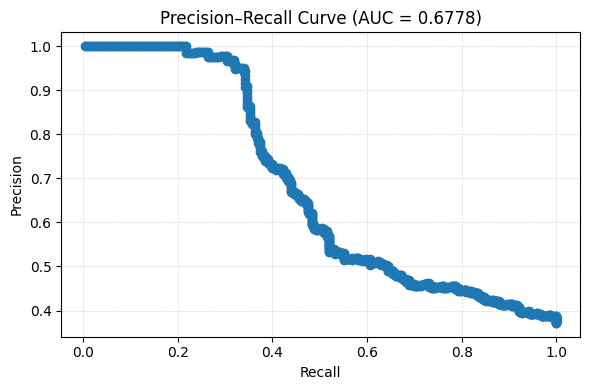

In [22]:
# === Single-cell PR curve (auto-detects format) ===
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# ---------- CONFIG ----------
txt_path = "darpa_anomaly.txt"   # <-- set to your input file
# ---------------------------

text = Path(txt_path).read_text(encoding="utf-8")
lines = [ln for ln in text.splitlines() if ln.strip()]

# Detect format
re_summary = re.compile(
    r"^\s*(?:\[[^\]]+\]\s*)?precision:\s*(\d*\.?\d+(?:[eE][-+]?\d+)?)\s*,\s*recall:\s*(\d*\.?\d+(?:[eE][-+]?\d+)?)",
    re.IGNORECASE,
)
re_pair = re.compile(
    r"^\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s+([01])\s*$"
)

n_summary = sum(1 for ln in lines if re_summary.match(ln))
n_pairs   = sum(1 for ln in lines if re_pair.match(ln))

if n_summary == 0 and n_pairs == 0:
    raise ValueError("Input not recognized. Expect either:\n"
                     "  [LABEL] precision: <num>, recall: <num>\n"
                     "or\n"
                     "  <score> <label(0/1)>")

# ========== MODE 1: Top-K summary points ==========
if n_summary >= n_pairs:
    prs = []
    for ln in lines:
        m = re_summary.match(ln)
        if m:
            p, r = map(float, m.groups())
            prs.append((p, r))
    if not prs:
        raise ValueError("No valid summary lines parsed.")
    df = pd.DataFrame(prs, columns=["precision","recall"]).sort_values("recall")
    precision = df["precision"].to_numpy()
    recall    = df["recall"].to_numpy()

    # PR-AUC (trapezoidal)
    auc = float(np.trapz(precision, recall))

    print(f"Detected format: Top-K summary points")
    print(f"PR-AUC (trapezoidal): {auc:.6f}")

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker="o", linestyle="-")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve (AUC = {auc:.4f})")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

# ========== MODE 2: Raw score/label pairs ==========
else:
    scores, labels = [], []
    for ln in lines:
        m = re_pair.match(ln)
        if m:
            s = float(m.group(1))
            y = int(m.group(2))
            scores.append(s); labels.append(y)

    if not scores:
        raise ValueError("No valid score/label lines parsed.")
    scores = np.asarray(scores, dtype=float)
    labels = np.asarray(labels, dtype=int)
    if labels.max() > 1 or labels.min() < 0:
        raise ValueError("Labels must be 0 or 1.")

    # Sort by score descending
    order = np.argsort(-scores)
    scores = scores[order]
    labels = labels[order]

    P = labels.sum()
    if P == 0:
        raise ValueError("No positive labels (1) found; PR curve undefined.")

    # Compute PR at each unique threshold (standard cumulative approach)
    tp = np.cumsum(labels)
    fp = np.cumsum(1 - labels)
    precision = tp / (tp + fp)
    recall = tp / P

    # Keep only the last index for each unique score (to avoid duplicates)
    # so the curve steps at unique thresholds
    _, last_idx = np.unique(scores, return_index=False, return_counts=False, return_inverse=False), None
    # Simpler: compress by change in score using where diff != 0
    # We'll take indices where score changes OR last point
    change = np.r_[True, np.diff(scores) != 0]
    precision = precision[change]
    recall    = recall[change]

    # PR-AUC (trapezoidal)
    auc = float(np.trapz(precision, recall))

    print(f"Detected format: score/label pairs")
    print(f"PR-AUC (trapezoidal): {auc:.6f}")

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker="o", linestyle="-")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve (AUC = {auc:.4f})")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()
